# Notebook 4: Cálculo de Energia

## Curso ABAR - Medições Inteligentes e Gestão Integrada

### Objetivo
Calcular a energia diária do gás a partir dos dados de volume e PCS, e comparar com os valores da planilha.

### Conceitos-chave
- **Energia = Volume × PCS**
  - Energia em **kcal** (quilocalorias)
  - Volume em **Nm³** (Normal metros cúbicos)
  - PCS em **kcal/Nm³**
- A comercialização de gás pode ser feita por **volume** ou por **energia**
- Variações no PCS fazem com que o mesmo volume de gás contenha quantidades diferentes de energia
- A análise de energia é mais precisa para fins comerciais que a análise de volume isolada

In [1]:
import sys
from pathlib import Path

# Configurar caminhos do projeto
PROJECT_ROOT = Path('.').resolve().parent if Path('.').resolve().name == 'notebooks' else Path('.').resolve()
sys.path.insert(0, str(PROJECT_ROOT / 'src'))
from config import DATA_DIR, GRAFICOS_DIR, EXCEL_DEFAULT

EXCEL_PATH = DATA_DIR / EXCEL_DEFAULT
GRAFICOS_DIR.mkdir(parents=True, exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

# Carregar volumes
df_vol = pd.read_excel(ARQUIVO_EXCEL, sheet_name='Vol Entrada Gas', header=1, usecols='B:D')
df_vol.columns = ['Data', 'Vol_Conc_Nm3d', 'Vol_Transp_Nm3d']
df_vol['Data'] = pd.to_datetime(df_vol['Data'], errors='coerce')
df_vol = df_vol.dropna(subset=['Data']).reset_index(drop=True)

# Carregar PCS (NOTA: aba tem espaço no final)
df_pcs = pd.read_excel(ARQUIVO_EXCEL, sheet_name='PCS Ent ', header=1, usecols='B:D')
df_pcs.columns = ['Data', 'PCS_Conc', 'PCS_Transp']
df_pcs['Data'] = pd.to_datetime(df_pcs['Data'], errors='coerce')
df_pcs = df_pcs.dropna(subset=['Data']).reset_index(drop=True)

# Carregar energia da planilha (para comparação)
# NOTA: Coluna B vazia nesta aba, dados começam na C
df_en_plan = pd.read_excel(ARQUIVO_EXCEL, sheet_name='Energia Ent', header=1, usecols='C:J')
df_en_plan.columns = ['Vol_Conc', 'PCS_Conc', 'Energia_Conc_Plan', 
                       'Vol_Transp', 'PCS_Transp', 'Energia_Transp_Plan',
                       'Dif_Abs_Plan', 'Dif_Pct_Plan']
# A coluna de data não está aqui, vamos usar o índice do df_vol
df_en_plan['Data'] = df_vol['Data'].values[:len(df_en_plan)] if len(df_vol) >= len(df_en_plan) else pd.NaT
df_en_plan = df_en_plan.dropna(subset=['Data']).reset_index(drop=True)

print(f'Volumes: {len(df_vol)} dias')
print(f'PCS: {len(df_pcs)} dias')
print(f'Energia (planilha): {len(df_en_plan)} dias')

In [2]:
# Carregar volumes
df_vol = pd.read_excel(EXCEL_PATH, sheet_name='Vol Entrada Gas', header=1, usecols='B:D')
df_vol.columns = ['Data', 'Vol_Conc_Nm3d', 'Vol_Transp_Nm3d']
df_vol['Data'] = pd.to_datetime(df_vol['Data'], errors='coerce')
for col in ['Vol_Conc_Nm3d', 'Vol_Transp_Nm3d']:
    df_vol[col] = pd.to_numeric(df_vol[col], errors='coerce')
df_vol = df_vol.dropna(subset=['Data']).reset_index(drop=True)

# Carregar PCS (espaço no final do nome da aba é intencional)
df_pcs = pd.read_excel(EXCEL_PATH, sheet_name='PCS Ent ', header=1, usecols='B:D')
df_pcs.columns = ['Data', 'PCS_Conc', 'PCS_Transp']
df_pcs['Data'] = pd.to_datetime(df_pcs['Data'], errors='coerce')
for col in ['PCS_Conc', 'PCS_Transp']:
    df_pcs[col] = pd.to_numeric(df_pcs[col], errors='coerce')
df_pcs = df_pcs.dropna(subset=['Data']).reset_index(drop=True)

# Carregar energia da planilha (para comparação)
# NOTA: Coluna B pode estar vazia na aba Energia Ent, dados começam na C
df_en_plan = pd.read_excel(EXCEL_PATH, sheet_name='Energia Ent', header=1, usecols='C:J')
df_en_plan.columns = ['Vol_Conc', 'PCS_Conc', 'Energia_Conc_Plan', 
                       'Vol_Transp', 'PCS_Transp', 'Energia_Transp_Plan',
                       'Dif_Abs_Plan', 'Dif_Pct_Plan']
for col in df_en_plan.columns:
    df_en_plan[col] = pd.to_numeric(df_en_plan[col], errors='coerce')
# Remover linhas sem dados antes de atribuir datas
df_en_plan = df_en_plan.dropna(subset=['Energia_Conc_Plan']).reset_index(drop=True)
# Usar datas do df_vol como referência
df_en_plan['Data'] = df_vol['Data'].values[:len(df_en_plan)]
df_en_plan = df_en_plan.dropna(subset=['Data']).reset_index(drop=True)

print(f'Volumes: {len(df_vol)} dias')
print(f'PCS: {len(df_pcs)} dias')
print(f'Energia (planilha): {len(df_en_plan)} dias')

Volumes: 183 dias
PCS: 183 dias
Energia (planilha): 183 dias


## 2. Cálculo da Energia

Aplicando a fórmula: **Energia (kcal) = Volume (Nm³) × PCS (kcal/Nm³)**

In [3]:
# Merge dos dados por data
df = pd.merge(df_vol, df_pcs, on='Data', how='inner')

# Calcular energia
df['Energia_Conc_Calc'] = df['Vol_Conc_Nm3d'] * df['PCS_Conc']
df['Energia_Transp_Calc'] = df['Vol_Transp_Nm3d'] * df['PCS_Transp']

# Diferenças
df['Dif_Energia_Abs'] = df['Energia_Conc_Calc'] - df['Energia_Transp_Calc']
df['Dif_Energia_Pct'] = (df['Dif_Energia_Abs'] / df['Energia_Conc_Calc']) * 100

# Converter para Gcal (Giga calorias) para facilitar leitura
df['Energia_Conc_Gcal'] = df['Energia_Conc_Calc'] / 1e6
df['Energia_Transp_Gcal'] = df['Energia_Transp_Calc'] / 1e6

print(f'Dias calculados: {len(df)}')
df[['Data', 'Vol_Conc_Nm3d', 'PCS_Conc', 'Energia_Conc_Calc', 'Energia_Conc_Gcal']].head()

Dias calculados: 183


,Data,Vol_Conc_Nm3d,PCS_Conc,Energia_Conc_Calc,Energia_Conc_Gcal
0,2025-04-01,8.394282e+05,9774.6934,8.205153e+09,8205.153164
1,2025-04-02,8.384109e+05,9629.9734,8.073874e+09,8073.874425
2,2025-04-03,8.020914e+05,9668.3980,7.754939e+09,7754.938646
3,2025-04-04,9.871601e+05,9614.4273,9.490979e+09,9490.979255
4,2025-04-05,1.067653e+06,9588.8016,1.023751e+10,10237.509199


## 3. Verificação com Planilha

Vamos comparar os valores que calculamos com os da aba "Energia Ent" para validar.

In [4]:
# Merge para comparação
df_verif = pd.merge(
    df[['Data', 'Energia_Conc_Calc']], 
    df_en_plan[['Data', 'Energia_Conc_Plan']], 
    on='Data', how='inner'
)

# Calcular diferença entre nosso cálculo e a planilha
df_verif['Dif_Verificacao'] = df_verif['Energia_Conc_Calc'] - df_verif['Energia_Conc_Plan']
df_verif['Dif_Verif_Pct'] = (df_verif['Dif_Verificacao'] / df_verif['Energia_Conc_Plan']) * 100

print('=== Verificação: Nosso Cálculo vs Planilha ===')
print(f'Diferença média: {df_verif["Dif_Verificacao"].mean():,.2f} kcal')
print(f'Diferença percentual média: {df_verif["Dif_Verif_Pct"].mean():.6f}%')
print(f'Diferença máxima: {df_verif["Dif_Verificacao"].abs().max():,.2f} kcal')
print(f'\nSe a diferença é próxima de zero, nosso cálculo está correto!')

=== Verificação: Nosso Cálculo vs Planilha ===
Diferença média: 0.00 kcal
Diferença percentual média: 0.000000%
Diferença máxima: 0.00 kcal

Se a diferença é próxima de zero, nosso cálculo está correto!


In [5]:
# Estatísticas de energia
print('=== Estatísticas de Energia ===')
stats = pd.DataFrame({
    'Energia Conc (kcal)': df['Energia_Conc_Calc'].agg(['mean', 'min', 'max']),
    'Energia Conc (Gcal)': df['Energia_Conc_Gcal'].agg(['mean', 'min', 'max']),
    'Energia Transp (Gcal)': df['Energia_Transp_Gcal'].agg(['mean', 'min', 'max'])
})
stats.index = ['Média', 'Mínimo', 'Máximo']
print(stats.to_string())
print(f'\n** Valor esperado: Média ~ 9.536 Gcal/dia **')

=== Estatísticas de Energia ===
        Energia Conc (kcal)  Energia Conc (Gcal)  Energia Transp (Gcal)
Média          9.536232e+09          9536.231887            9536.227817
Mínimo         4.779246e+09          4779.246288            4779.345390
Máximo         1.173053e+10         11730.525650           11731.137710

** Valor esperado: Média ~ 9.536 Gcal/dia **


## 4. Gráficos

### 4.1 Série Temporal da Energia Diária

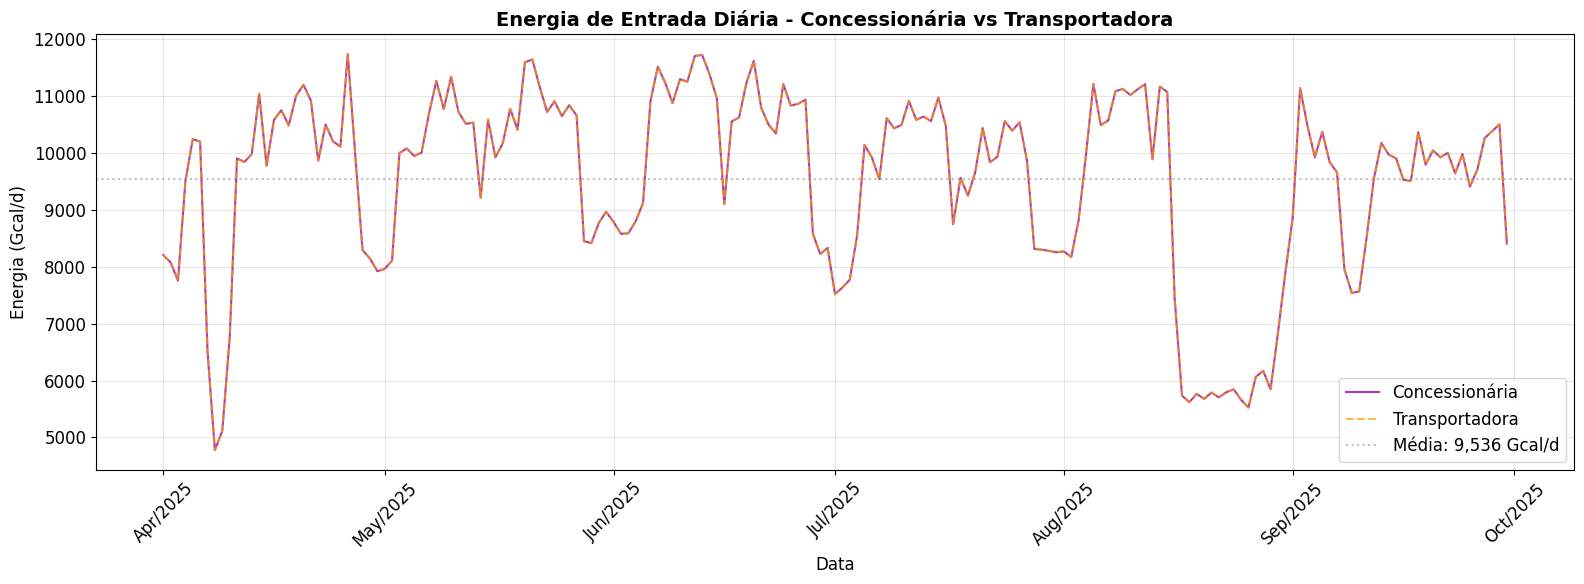

In [6]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df['Data'], df['Energia_Conc_Gcal'], 
        label='Concessionária', color='#9C27B0', linewidth=1.5, alpha=0.9)
ax.plot(df['Data'], df['Energia_Transp_Gcal'], 
        label='Transportadora', color='#FF9800', linewidth=1.5, alpha=0.7, linestyle='--')

media = df['Energia_Conc_Gcal'].mean()
ax.axhline(y=media, color='gray', linestyle=':', alpha=0.5, 
           label=f'Média: {media:,.0f} Gcal/d')

ax.set_title('Energia de Entrada Diária - Concessionária vs Transportadora', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Energia (Gcal/d)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'energia_serie.png'), dpi=150, bbox_inches='tight')
plt.show()

### 4.2 Diferenças de Energia

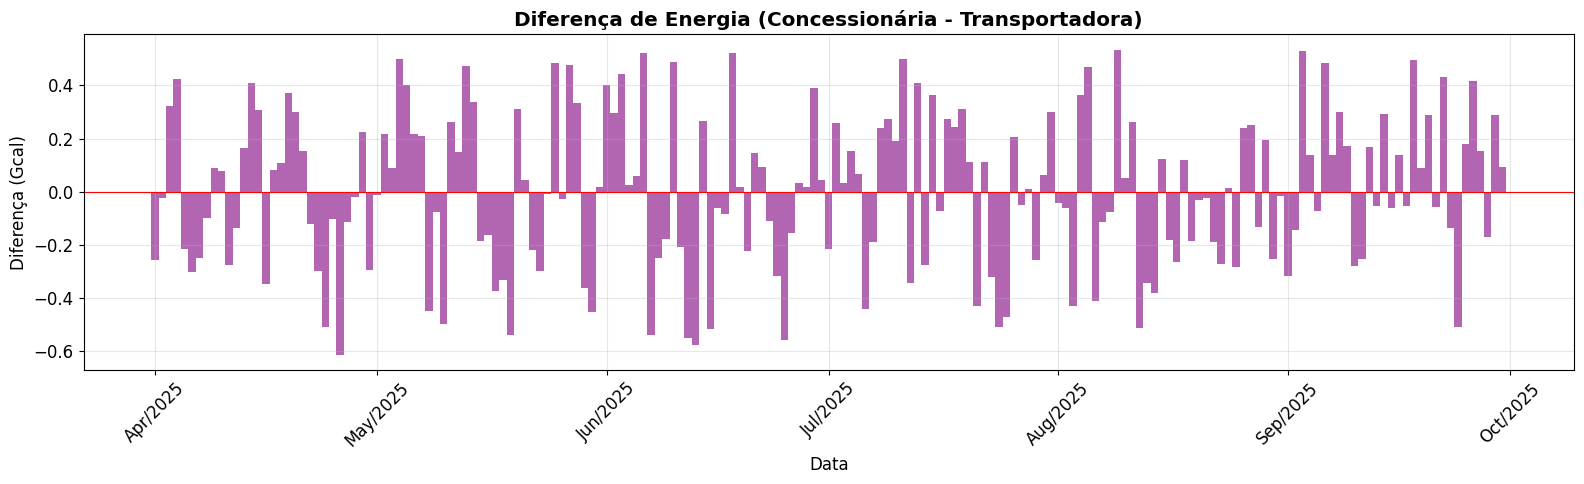

In [7]:
fig, ax = plt.subplots(figsize=(16, 5))

ax.bar(df['Data'], df['Dif_Energia_Abs'] / 1e6, color='purple', alpha=0.6, width=1)
ax.axhline(y=0, color='red', linewidth=0.8)
ax.set_title('Diferença de Energia (Concessionária - Transportadora)', fontweight='bold')
ax.set_ylabel('Diferença (Gcal)')
ax.set_xlabel('Data')
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'energia_diferencas.png'), dpi=150, bbox_inches='tight')
plt.show()

### 4.3 Energia Mensal Acumulada

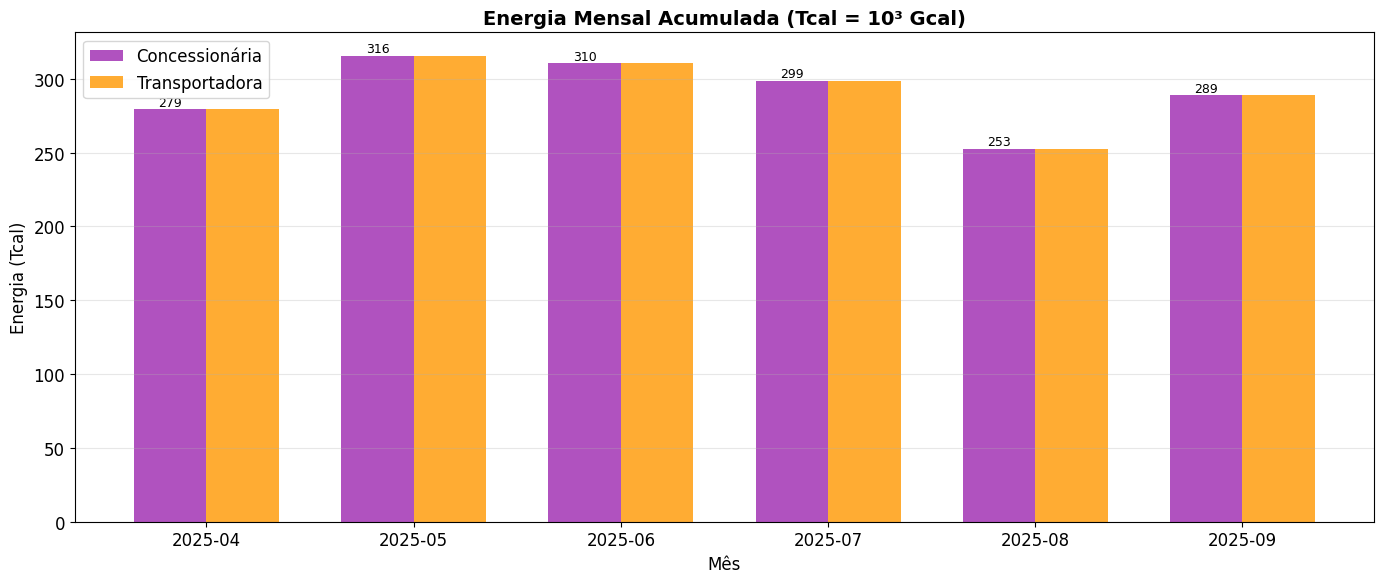


Energia total Concessionária: 1,745,130 Gcal (1.75 Pcal)
Energia total Transportadora: 1,745,130 Gcal (1.75 Pcal)


In [8]:
df['Mes'] = df['Data'].dt.to_period('M').astype(str)

# Agrupar por mês
mensal = df.groupby('Mes').agg({
    'Energia_Conc_Gcal': 'sum',
    'Energia_Transp_Gcal': 'sum'
}).reset_index()

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(mensal))
width = 0.35

bars1 = ax.bar(x - width/2, mensal['Energia_Conc_Gcal'] / 1000, width, 
               label='Concessionária', color='#9C27B0', alpha=0.8)
bars2 = ax.bar(x + width/2, mensal['Energia_Transp_Gcal'] / 1000, width, 
               label='Transportadora', color='#FF9800', alpha=0.8)

# Rótulos
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{bar.get_height():,.0f}', ha='center', va='bottom', fontsize=9)

ax.set_title('Energia Mensal Acumulada (Tcal = 10³ Gcal)', fontsize=14, fontweight='bold')
ax.set_xlabel('Mês')
ax.set_ylabel('Energia (Tcal)')
ax.set_xticks(x)
ax.set_xticklabels(mensal['Mes'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'energia_mensal.png'), dpi=150, bbox_inches='tight')
plt.show()

# Total do período
total_conc = df['Energia_Conc_Gcal'].sum()
total_transp = df['Energia_Transp_Gcal'].sum()
print(f'\nEnergia total Concessionária: {total_conc:,.0f} Gcal ({total_conc/1e6:,.2f} Pcal)')
print(f'Energia total Transportadora: {total_transp:,.0f} Gcal ({total_transp/1e6:,.2f} Pcal)')

### 4.4 Scatter Plot - Volume vs Energia

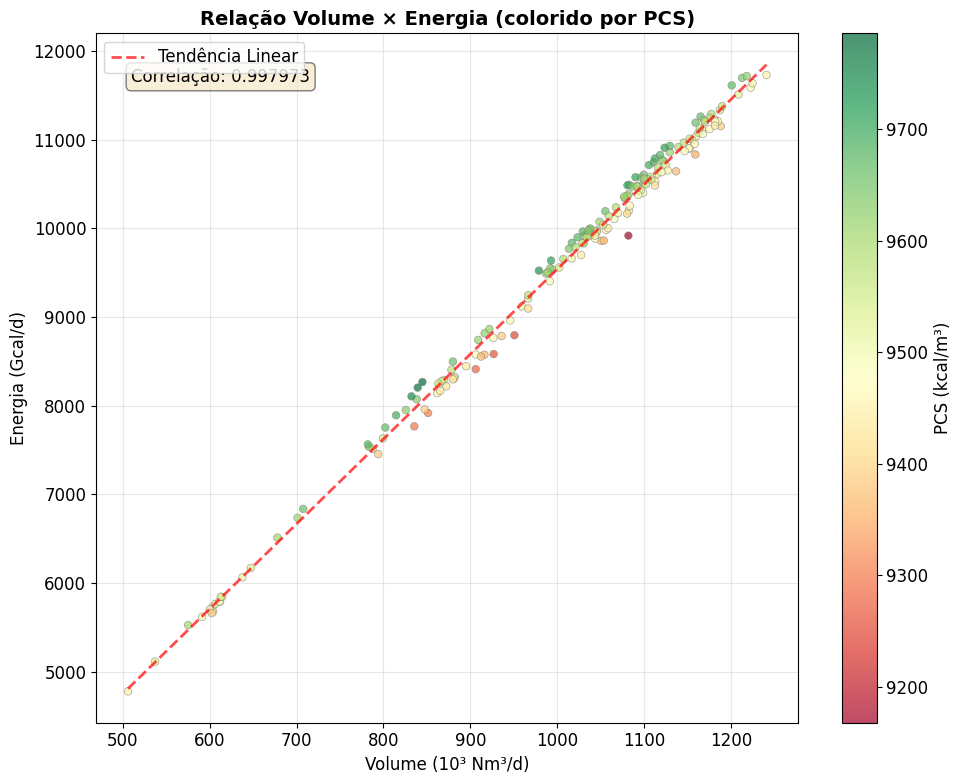

A relação é quase perfeitamente linear (r = 0.997973)
Desvios são causados pela variação do PCS ao longo do tempo.


In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(df['Vol_Conc_Nm3d'] / 1000, df['Energia_Conc_Gcal'],
                     c=df['PCS_Conc'], cmap='RdYlGn', alpha=0.7, s=30, edgecolors='gray', linewidth=0.5)

# Linha de tendência
z = np.polyfit(df['Vol_Conc_Nm3d'] / 1000, df['Energia_Conc_Gcal'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df['Vol_Conc_Nm3d'].min() / 1000, df['Vol_Conc_Nm3d'].max() / 1000, 100)
ax.plot(x_trend, p(x_trend), 'r--', linewidth=2, alpha=0.7, label='Tendência Linear')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('PCS (kcal/m³)')

ax.set_title('Relação Volume × Energia (colorido por PCS)', fontsize=14, fontweight='bold')
ax.set_xlabel('Volume (10³ Nm³/d)')
ax.set_ylabel('Energia (Gcal/d)')
ax.legend()
ax.grid(True, alpha=0.3)

# Correlação
corr = df['Vol_Conc_Nm3d'].corr(df['Energia_Conc_Calc'])
ax.text(0.05, 0.95, f'Correlação: {corr:.6f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'energia_scatter.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f'A relação é quase perfeitamente linear (r = {corr:.6f})')
print(f'Desvios são causados pela variação do PCS ao longo do tempo.')

## 5. Conclusões

### Observações:
- **Energia = Volume × PCS** foi validada - nossos cálculos batem com a planilha
- Energia média diária: **~9.536 Gcal/dia**
- A relação volume-energia é quase linear, com variações causadas pelo PCS
- Diferenças entre Concessionária e Transportadora são mínimas
- A análise por energia captura tanto variações de volume quanto de qualidade do gás